In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import

In [3]:
import pandas
import numpy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

In [4]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [5]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/1016_vtx.root'))

## Define label
`label` = `signB` * `signVtx` > 0
* same sign of B and vtx -> label = 1
* opposite sign of B and vtx -> label = 0

In [6]:
event_id_column = 'event_id'
data[event_id_column] = data.runNum.apply(str) + '_' + (data.evtNum.apply(int)).apply(str)
# reconstructing sign of B
data['signB'] = data.tagAnswer * (2 * data.iscorrect - 1)
# assure sign is +1 or -1
data['signVtx'] = (data.signVtx.values > 0) * 2 - 1
data['label'] = (data.signVtx.values * data.signB.values > 0) * 1

In [7]:
data.head()

,iscorrect,tagAnswer,signVtx,tagger,evtNum,runNum,nnkrec,mult,ptB,etaB,...,svp,om_muon,om_ele,om_kaon,om_same,om_vtx,N_sig_sw,event_id,signB,label
0,0,1,-1,0,490856995,115839,3,19,-0.382002,-6.307031,...,5.458805,0,0,0,0,0,1.034008,115839_490856995,-1,1
1,1,1,-1,0,822264706,115839,2,10,2.117417,-2.673835,...,3.035841,0,0,0,0,0,1.091844,115839_822264706,1,0
2,1,1,-1,0,68238381,115839,4,16,0.788837,-4.426422,...,4.479315,0,0,0,0,0,-0.263734,115839_68238381,1,0
3,1,1,-1,0,3537659,115839,3,38,0.070327,-4.690033,...,4.092348,0,0,0,0,0,1.062726,115839_3537659,1,0
4,0,1,-1,0,2079583,115839,2,31,1.172778,-3.726187,...,2.617929,0,0,0,0,0,0.949457,115839_2079583,-1,1


In [8]:
get_events_statistics(data)

{'Events': 427102, 'tracks': 427103}

In [9]:
N_pass = get_events_number(data)
tagging_efficiency = 1. * N_pass / get_N_B_events()
tagging_efficiency_delta = sqrt(N_pass) / get_N_B_events()
print tagging_efficiency, tagging_efficiency_delta

0.397426963471 0.000731430257878


In [10]:
Bdata_tracks = pandas.read_csv('models/Bdata_tracks_PID_less.csv')

In [11]:
Bdata_tracks.index = Bdata_tracks.event_id

In [12]:
data['initial_pred'] = Bdata_tracks.ix[data.event_id, 'track_relation_prob'].values

### Define B-like events for training and others for prediction

In [13]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 247173, 'tracks': 247173}

### Define features

In [14]:
features =  ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
             'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']

## Find good vtx to define sign B

trying to guess sign of B based on sign of vtx. If the guess is good, the vtx will be used on next step to train classifier.

### 2-folding random forest selection for right tagged events

In [15]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw)

## Training on all vtx
in this case we don't use preselection with RandomForest

### DT full

In [17]:
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

In [39]:
from hep_ml.losses import HessianLossFunction
from hep_ml.commonutils import check_sample_weight
from scipy.special import expit

class LogLossFunctionTagging(HessianLossFunction):
    """Logistic loss function (logloss), aka binomial deviance, aka cross-entropy,
       aka log-likelihood loss.
    """  
    def fit(self, X, y, sample_weight):
        self.sample_weight = check_sample_weight(y, sample_weight=sample_weight,
                                                 normalize=True, normalize_by_class=True)
        self.initial_pred = numpy.log(X['initial_pred'].values)
        self.y_signed = 2 * y - 1
        self.minus_y_signed = - self.y_signed
        self.y_signed_times_weights = self.y_signed * self.sample_weight
        HessianLossFunction.fit(self, X, y, sample_weight=self.sample_weight)
        return self

    def __call__(self, y_pred):
        y_pred = y_pred + self.initial_pred
        return numpy.sum(self.sample_weight * numpy.logaddexp(0, self.minus_y_signed * y_pred))

    def negative_gradient(self, y_pred):
        y_pred = y_pred + self.initial_pred
        return self.y_signed_times_weights * expit(self.minus_y_signed * y_pred)

    def hessian(self, y_pred):
        y_pred = y_pred + self.initial_pred
        expits = expit(y_pred)
        return self.sample_weight * expits * (1 - expits)

    def prepare_tree_params(self, y_pred):
        y_pred = y_pred + self.initial_pred
        return self.y_signed * expit(self.minus_y_signed * y_pred), self.sample_weight

0.66117292642593384

In [40]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1500, depth=6, 
                                  max_features=8, loss=LogLossFunctionTagging(regularization=100), train_features=features)
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11,
                               features=features + ['initial_pred'])
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 1min 32s, sys: 4 ms, total: 1min 32s
Wall time: 1min 32s


KFold prediction using folds column


In [62]:
from scipy.special import expit, logit

In [72]:
data_temp = data_sw_not_passed

In [73]:
print roc_auc_score(data_temp.signB.values, data_temp['initial_pred'].values, sample_weight=data_temp.N_sig_sw.values)

0.715624213219


In [75]:
p = tt_folding.predict_proba(data_temp)[:, 1]
print roc_auc_score(data_temp.signB.values,
                    log(data_temp['initial_pred'].values) + logit(p) * data_temp.signB.values,
                    sample_weight=data_temp.N_sig_sw.values)

KFold prediction using random classifier (length of data passed not equal to length of train)
0.68956130743


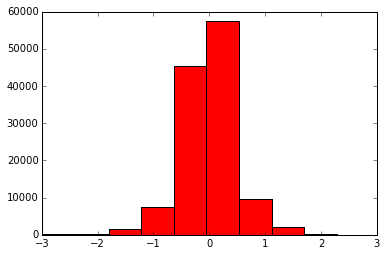

In [66]:
hist(tt_folding.estimators[0].loss.initial_pred, )
pass

### Report for all vtx

In [43]:
report = ClassificationReport({'tt': tt_folding}, data_sw_passed_lds)

KFold prediction using folds column


KFold prediction using folds column


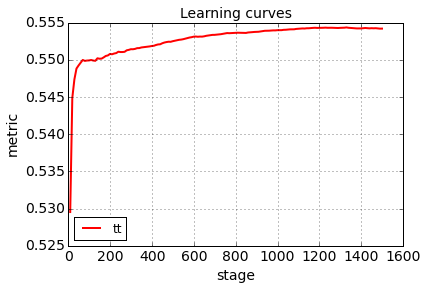

In [44]:
report.learning_curve(RocAuc())

In [45]:
report.compute_metric(RocAuc())

OrderedDict([('tt', 0.55419415895346669)])

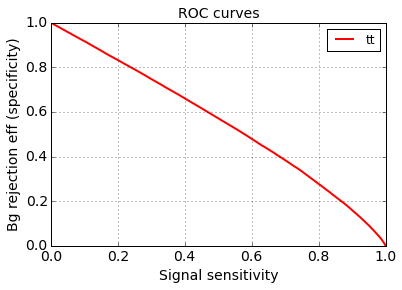

In [46]:
report.roc()

--------

## Calibrating results $p(\text{vrt same sign}|B)$ and combining them

In [47]:
models = []

In [48]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


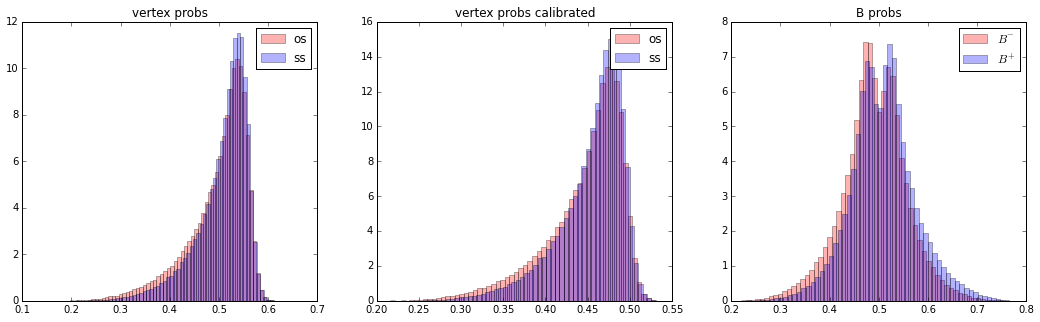

AUC for tagged: 0.594398881774 AUC with untag: 0.546054631136
mean AUC after calibration: 0.594058612825 1.23619450273e-06


In [49]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 
                                                      logistic=True, name="tt-log",
                                                      sign_part_column='signVtx', part_name='vertex'))

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


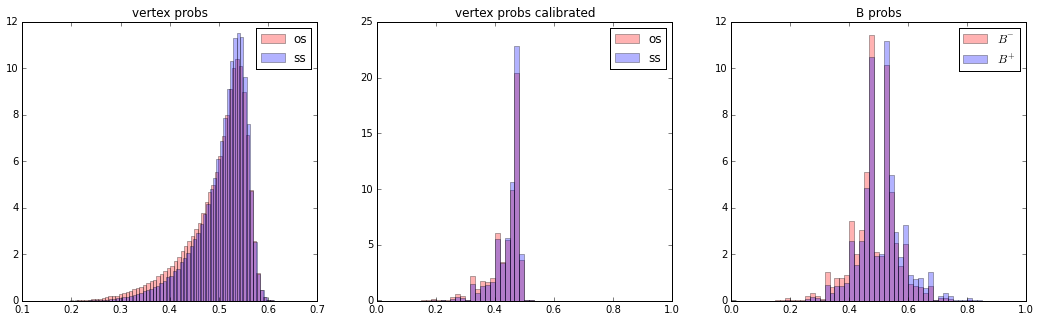

AUC for tagged: 0.594148878677 AUC with untag: 0.546551916187
mean AUC after calibration: 0.593875817111 1.55377219749e-06


In [50]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 
                                                      logistic=False, name="tt-iso",
                                                      sign_part_column='signVtx', part_name='vertex'))

# Comparison of different models

In [51]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,39.742696,0.073143,0.027535,0.000500,1.094329,0.019965,54.605463,0
0,tt-iso,39.742696,0.073143,0.026088,0.003449,1.036793,0.137068,54.655192,0


In [31]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,39.742696,0.073143,0.027504,0.000676,1.093065,0.026943,54.633088,0
0,tt-iso,39.742696,0.073143,0.030170,0.004600,1.199048,0.182819,54.656729,0


## Implementing the best vertex model

and saving its predictions

In [52]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


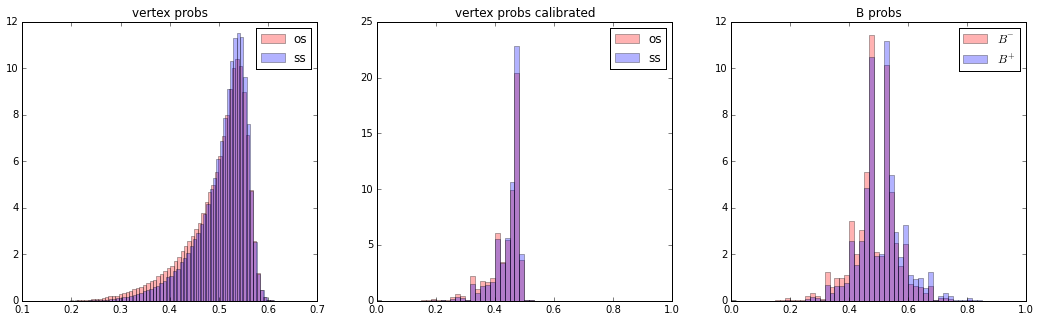

AUC for tagged: 0.594148878677 AUC with untag: 0.546551916187


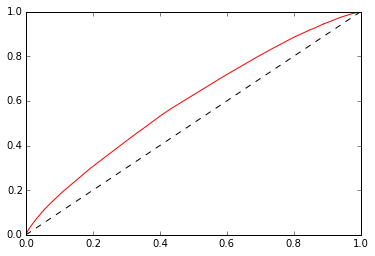

In [53]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], logistic=False,
                                               sign_part_column='signVtx', part_name='vertex')

In [54]:
Bdata_prepared.to_csv('models/Bdata_vertex_new_loss.csv', header=True, index=False)